# 0. Becquerel Overview

### Description

Becquerel is a Python package for analyzing nuclear spectroscopic measurements. We wanted to consolodate some tools we end up rewriting often when performing analysis of spectra. We also wanted to replicate some features of PeakEasy (notably fileIO) all within a Python environment.

- Spectrum file type reading and writing
- Operations on spectra
  - rebinning
  - combination / subtraction
- Fitting spectral features
- Performing detector calibrations
- Interpreting measurement results

It is intended to be general-purpose enough that it can be useful to anyone from an undergraduate taking a laboratory course to the advanced researcher.

### Distribution:

- Open source: https://github.com/lbl-anp/becquerel
- Continuous Integration: https://travis-ci.org/lbl-anp/becquerel
- Modified (for UC Regents) [3 Clause BSD License](https://opensource.org/licenses/BSD-3-Clause) 
- <img src="https://upload.wikimedia.org/wikipedia/commons/b/bf/License_icon-bsd.svg" alt="BSD" style="width: 30px;" align="left"/>

### Installation

- Python 2/3 package
- Normal scientific Python distribution dependancies with a couple extras:
    - beautifulsoup4
    - future
    - html5lib
    - lxml
    - matplotlib
    - numba
    - numpy
    - pandas
    - python-dateutil
    - requests
    - scipy
    - setuptools
    - six
    - uncertainties

```bash
git clone https://github.com/lbl-anp/becquerel.git
cd becquerel
pip install -r requirements.txt
python setup.py install
```

### Contributors as of April 9, 2018:

- bplimley
- markbandstra
- thjoshi
- jccurtis
- chunhochow
- *alihanks*

In [1]:
%pylab inline
import pandas as pd
import becquerel as bq

Populating the interactive namespace from numpy and matplotlib


# Ideas:

Spectrum Class
- Reading
- add/sub (Spectrum)
- mul/div (scalar)


# 1. `bq.Spectrum`

The core class in `bq` is `Spectrum`. This contains a variety of tools for handling **single spectrum** data.

In [2]:
#print(bq.Spectrum.__doc__)

In [3]:
#print(bq.Spectrum.__init__.__doc__)

## 1.1 From scratch

In [4]:
c, _ = np.histogram(np.random.poisson(50, 1000), bins=np.arange(101))
spec = bq.Spectrum(counts=c, livetime=60.)
spec

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       60.0
    is_calibrated:  False
    num_channels:   100
    gross_counts:   1000+/-32
    gross_cps:      16.7+/-0.5
    filename:       None

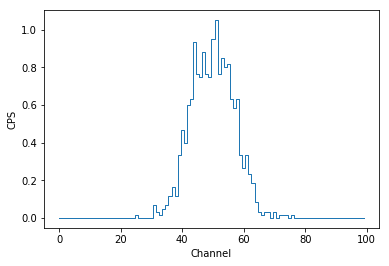

In [5]:
spec.plot(x_data='channels')

In [6]:
try:
    spec.plot(x_data='keV')
except bq.SpectrumError as e:
    print('ERROR:', e)
    plt.close('all')

ERROR: Spectrum is not calibrated


## 1.2 Energy Calibration Models

Base class for energy calibration models: `EnergyCalBase`. Currently implmented:

- `LinearEnergyCal`

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       60.0
    is_calibrated:  True
    num_channels:   100
    gross_counts:   1000+/-32
    gross_cps:      16.7+/-0.5
    filename:       None


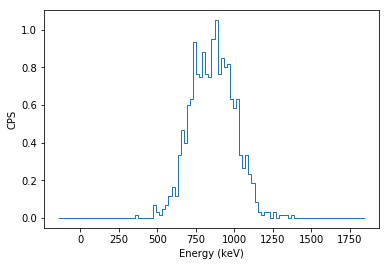

In [7]:
chlist = (40, 80)
kevlist = (661.7, 1460.83)
cal = bq.LinearEnergyCal.from_points(chlist=chlist, kevlist=kevlist)
cal.update_fit()
spec.apply_calibration(cal)
print(spec)
spec.plot(x_data='keV')

In [8]:
# New spec
c, _ = np.histogram(np.random.poisson(50, 1000), bins=np.arange(101))
spec2 = bq.Spectrum(counts=c, livetime=60.)
spec2

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       60.0
    is_calibrated:  False
    num_channels:   100
    gross_counts:   1000+/-33
    gross_cps:      16.7+/-0.5
    filename:       None

In [9]:
spec2.calibrate_like(spec)
spec2

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       60.0
    is_calibrated:  True
    num_channels:   100
    gross_counts:   1000+/-33
    gross_cps:      16.7+/-0.5
    filename:       None

## 1.3 From File

`becquerel` currently provides parsers for:

- `SPE`
- `SPC`
- `CNF`

In [10]:
spec = bq.Spectrum.from_file('../tests/samples/1110C NAA cave pottery.Spe')
spec

SpeFile: Reading file ../tests/samples/1110C NAA cave pottery.Spe


becquerel.Spectrum
    start_time:     2017-04-25 12:54:27
    stop_time:      2017-04-25 17:30:24
    realtime:       16557.0
    livetime:       16543.0
    is_calibrated:  True
    num_channels:   16384
    gross_counts:   (3.047+/-0.006)e+05
    gross_cps:      18.419+/-0.034
    filename:       ../tests/samples/1110C NAA cave pottery.Spe

In [11]:
spec.is_calibrated

True

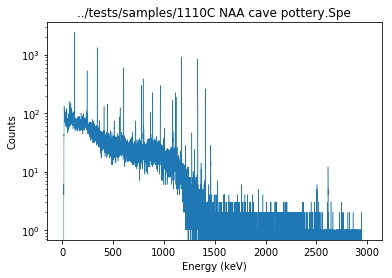

In [12]:
spec.plot(yscale='log', linewidth=0.5, y_data='counts')

In [13]:
%%capture
spec = bq.Spectrum.from_file('../tests/samples/01122014152731-GT01122014182338-GA37.4963000N-GO122.4633000W.cnf')

In [14]:
spec

becquerel.Spectrum
    start_time:     2014-01-12 15:12:28.125000
    stop_time:      2014-01-12 15:26:37.635000
    realtime:       849.5099998999999
    livetime:       841.4199999
    is_calibrated:  True
    num_channels:   4096
    gross_counts:   (6.837+/-0.008)e+05
    gross_cps:      812.5+/-1.0
    filename:       ../tests/samples/01122014152731-GT01122014182338-GA37.4963000N-GO122.4633000W.cnf

In [15]:
%%capture
spec = bq.Spectrum.from_file('../tests/samples/Alcatraz14.Spc')

In [16]:
spec

becquerel.Spectrum
    start_time:     2012-09-17 13:41:07
    stop_time:      2012-09-17 13:41:07
    realtime:       905.0
    livetime:       900.0
    is_calibrated:  True
    num_channels:   8192
    gross_counts:   (1.330+/-0.004)e+05
    gross_cps:      147.8+/-0.4
    filename:       ../tests/samples/Alcatraz14.Spc

## 1.4 Background Subtraction

In [17]:
spec = bq.Spectrum.from_file('../tests/samples/1110C NAA cave pottery.Spe')
print(spec)
bkg = bq.Spectrum.from_file('../tests/samples/1110C NAA cave background May 2017.spe')
print(bkg)

SpeFile: Reading file ../tests/samples/1110C NAA cave pottery.Spe
becquerel.Spectrum
    start_time:     2017-04-25 12:54:27
    stop_time:      2017-04-25 17:30:24
    realtime:       16557.0
    livetime:       16543.0
    is_calibrated:  True
    num_channels:   16384
    gross_counts:   (3.047+/-0.006)e+05
    gross_cps:      18.419+/-0.034
    filename:       ../tests/samples/1110C NAA cave pottery.Spe
SpeFile: Reading file ../tests/samples/1110C NAA cave background May 2017.spe
becquerel.Spectrum
    start_time:     2017-04-26 11:05:11
    stop_time:      2017-05-01 12:43:34
    realtime:       437903.0
    livetime:       437817.0
    is_calibrated:  True
    num_channels:   16384
    gross_counts:   (1.0529+/-0.0010)e+06
    gross_cps:      2.4049+/-0.0023
    filename:       ../tests/samples/1110C NAA cave background May 2017.spe


In [18]:
bkgsub = spec - bkg
print('Total pottery countrate:    {:6.3f}'.format(np.sum(spec.cps)))
print('Total background countrate: {:6.3f}'.format(np.sum(bkg.cps)))
print('Total subtracted countrate: {:6.3f}'.format(np.sum(bkgsub.cps)))

Total pottery countrate:    18.419+/- 0.034
Total background countrate:  2.405+/- 0.002
Total subtracted countrate: 16.014+/- 0.034


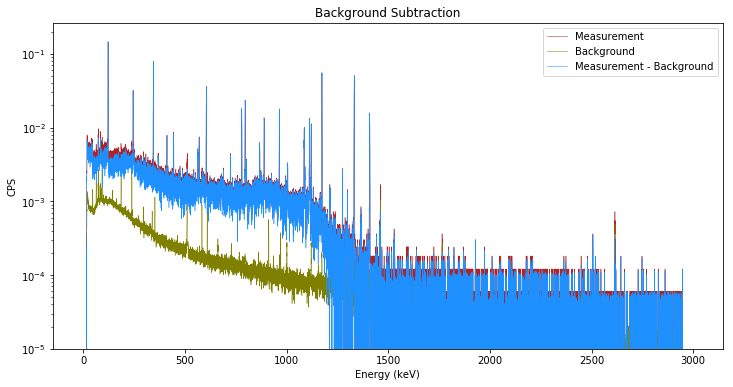

In [19]:
ax = spec.plot(color='firebrick', linewidth=0.5, yscale='log', figsize=(12, 6), label='Measurement')
bkg.plot(ax=ax, color='olive', linewidth=0.5, label='Background')
bkgsub.plot(ax=ax, color='dodgerblue', linewidth=0.5, label='Measurement - Background')
ax.set_ylim(bottom=1e-5)
ax.set_title('Background Subtraction')
ax.legend()

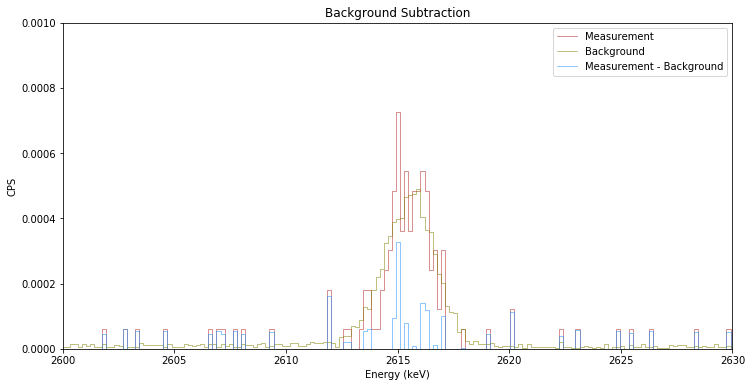

In [20]:
# Is there any Tl-208 in the background-subtracted spectrum?
ax = spec.plot(color='firebrick', linewidth=0.5, yscale='linear', figsize=(12, 6), label='Measurement')
bkg.plot(ax=ax, color='olive', linewidth=0.5, label='Background')
bkgsub.plot(ax=ax, color='dodgerblue', linewidth=0.5, label='Measurement - Background')
ax.set_ylim(bottom=1e-5)
ax.set_title('Background Subtraction')
ax.legend()
plt.xlim(2600, 2630)
plt.ylim(0, 0.001);

## 1.5 Rebinning

- deterministic (interpolation): `interpolation`
- stochastic (convert to listmode): `listmode`

In [21]:
bkg_rebin = bkg.rebin(np.linspace(0., 3000., 16000))

In [22]:
try:
    bkgsub = spec - bkg_rebin
except bq.SpectrumError as e:
    print('ERROR:', e)

ERROR: Cannot add/subtract spectra of different lengths


In [23]:
bkg_rebin2 = bkg_rebin.rebin_like(spec)

In [24]:
spec - bkg_rebin2

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       nan
    is_calibrated:  True
    num_channels:   16384
    gross_counts:   None
    gross_cps:      16.014+/-0.034
    filename:       None

## 1.6 Scaling

In [25]:
spec = bq.Spectrum.from_file('../tests/samples/1110C NAA cave pottery.Spe')
spec * 2.

SpeFile: Reading file ../tests/samples/1110C NAA cave pottery.Spe


becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       None
    is_calibrated:  True
    num_channels:   16384
    gross_counts:   (6.094+/-0.011)e+05
    gross_cps:      None
    filename:       None

In [26]:
spec.downsample(2, handle_livetime='reduce')

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       8271.5
    is_calibrated:  True
    num_channels:   16384
    gross_counts:   (1.527+/-0.004)e+05
    gross_cps:      18.46+/-0.05
    filename:       None

# 2. `bq.Isotope` & `bq.IsotopeQuantity`

## 2.1 Multiple ways to construct

In [27]:
i1 = bq.Isotope('Cs-137')
i2 = bq.Isotope('137CS')
i3 = bq.Isotope('Cs', 137)
i4 = bq.Isotope('Cesium-137')
i5 = bq.Isotope('137CAESIUM')
print(i1, i2, i3, i4, i5)
print(i1 == i2 == i3 == i4 == i5)

Cs-137 Cs-137 Cs-137 Cs-137 Cs-137
True


## 2.2 Isotope names and properties

In [28]:
iso = bq.Isotope('Tc-99m')
print(iso)
print('{:%n(%s)-%a%m Z=%z}'.format(iso))
print('name:', iso.name)
print('symbol:', iso.symbol)
print('Z:', iso.Z)
print('A:', iso.A)
print('N:', iso.N)
print('m:', iso.m)
print('half-life: {:.2f} hr'.format(iso.half_life / 3600))

Tc-99m
Technetium(Tc)-99m Z=43
name: Technetium
symbol: Tc
Z: 43
A: 99
N: 56
m: m
half-life: 6.01 hr


## 2.3 Source activity on a given date

Here's a check source activity on today's date:

In [29]:
ba133_chk = bq.IsotopeQuantity('ba133', date='2013-05-01', uci=10.02)
ba133_chk.uci_now()

7.243108683596727

Or for another date:

In [30]:
ba133_chk.uci_at('2018-02-16')

7.311855859452171

## 2.4 More isotope properties

Isotope properties such as half-life, stability, and natural abundance are available:

In [31]:
for a in range(37, 45):
    iso = bq.Isotope('Potassium', a)
    print('')
    print('Isotope: {}'.format(iso))
    print('    Spin-parity: {}'.format(iso.j_pi))
    if iso.abundance is not None:
        print('    Abundance:   {:.2f}%'.format(iso.abundance))
    print('    Stable?      {}'.format(iso.is_stable))
    if not iso.is_stable:
        print('    Half-life:   {:.3e} years'.format(iso.half_life / 365.25 / 24 / 3600))
        print('    Decay modes: {}'.format(iso.decay_modes))


Isotope: K-37
    Spin-parity: 3/2+
    Stable?      False
    Half-life:   3.885e-08 years
    Decay modes: (['EC'], [100.0])

Isotope: K-38
    Spin-parity: 3+
    Stable?      False
    Half-life:   1.452e-05 years
    Decay modes: (['EC'], [100.0])

Isotope: K-39
    Spin-parity: 3/2+
    Abundance:   93.26+/-0.00%
    Stable?      True

Isotope: K-40
    Spin-parity: 4-
    Abundance:   0.01+/-0.00%
    Stable?      False
    Half-life:   1.248e+09 years
    Decay modes: (['B-', 'EC'], [89.28, 10.72])

Isotope: K-41
    Spin-parity: 3/2+
    Abundance:   6.73+/-0.00%
    Stable?      True

Isotope: K-42
    Spin-parity: 2-
    Stable?      False
    Half-life:   1.409e-03 years
    Decay modes: (['B-'], [100.0])

Isotope: K-43
    Spin-parity: 3/2+
    Stable?      False
    Half-life:   2.544e-03 years
    Decay modes: (['B-'], [100.0])

Isotope: K-44
    Spin-parity: 2-
    Stable?      False
    Half-life:   4.208e-05 years
    Decay modes: (['B-'], [100.0])


# 3. `bq.nndc`

## 3.1 Source lines and branching ratios

Here are the gamma-ray lines above 5% branching ratio from Co-60:

In [32]:
rad = bq.nndc.fetch_decay_radiation(nuc='Co-60', type='Gamma', i_range=(5, None))
cols = ['Z', 'Element', 'A', 'Decay Mode', 'Radiation', 'Radiation Energy (keV)',
        'Radiation Intensity (%)', 'Parent Energy Level (MeV)']
display(rad[cols])

,Z,Element,A,Decay Mode,Radiation,Radiation Energy (keV),Radiation Intensity (%),Parent Energy Level (MeV)
0,27,CO,60,IT,G,6.915,9.1+/-0.4,0.058603+/-0.000007
1,27,CO,60,IT,G,6.93,18.0+/-0.8,0.058603+/-0.000007
2,27,CO,60,B-,G,1173.2280+/-0.0030,99.850+/-0.030,0
3,27,CO,60,B-,G,1332.492+/-0.004,99.9826+/-0.0006,0


# 4. `bq.xcom`

## 4.1 Cross section data for an element (Pb)

NIST XCOM data can be queried in `becquerel`:

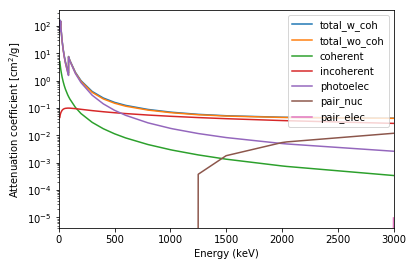

In [33]:
# query XCOM by element symbol
data = bq.xcom.fetch_xcom_data('Pb', e_range_kev=[10., 3000.])

plt.figure()
for field in ['total_w_coh', 'total_wo_coh', 'coherent', 'incoherent',
              'photoelec', 'pair_nuc', 'pair_elec']:
    plt.semilogy(data.energy, data[field], label=field)
plt.xlim(0, 3000)
plt.xlabel('Energy (keV)')
plt.ylabel(r'Attenuation coefficient [cm$^2$/g]')
plt.legend()
plt.show()

## 4.2 Mean free path of photons in lead

NIST XCOM data can be queried in `becquerel`, as well as standard properties of elements and materials. Here we query data for lead and use it to calculate the mean free path:

,Z,Symbol,Element,Z_over_A,I_eV,Density
0,1,H,Hydrogen,0.99212,19.2,0.000084
1,2,He,Helium,0.49968,41.8,0.000166
2,3,Li,Lithium,0.43221,40.0,0.534000
3,4,Be,Beryllium,0.44384,63.7,1.848000
4,5,B,Boron,0.46245,76.0,2.370000


density (g/cm^3): 11.35


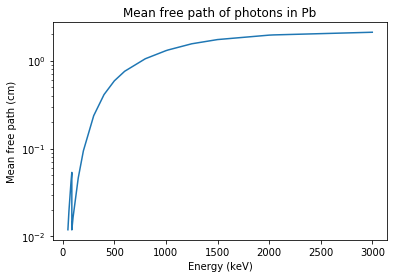

In [34]:
symbol = 'Pb'

# retrieve NIST element data
elem_dat = bq.materials.fetch_element_data()
display(elem_dat.head())
density = elem_dat.Density[elem_dat.Symbol == symbol].values[0]
print('density (g/cm^3):', density)

# retrieve NIST XCOM cross sections
xd = bq.xcom.fetch_xcom_data(symbol, e_range_kev=[50., 3000.])

# calculate mean free path
mfp_cm = 1 / (density * xd.total_wo_coh.values)

plt.figure()
plt.title('Mean free path of photons in ' + symbol)
plt.semilogy(xd.energy, mfp_cm)
plt.xlabel('Energy (keV)')
plt.ylabel('Mean free path (cm)')
plt.show()

## 4.3 Mean free path of photons in air

,Material,Z_over_A,I_eV,Density,Composition_Z,Composition_symbol
0,A-150 Tissue-Equivalent Plastic,0.54903,65.1,1.127000,"[1: 0.101330, 6: 0.775498, 7: 0.035057, 8: 0.0...","[H 0.101330, C 0.775498, N 0.035057, O 0.05231..."
1,Adipose Tissue (ICRU-44),0.55579,64.8,0.950000,"[1: 0.114000, 6: 0.598000, 7: 0.007000, 8: 0.2...","[H 0.114000, C 0.598000, N 0.007000, O 0.27800..."
2,"Air, Dry (near sea level)",0.49919,85.7,0.001205,"[6: 0.000124, 7: 0.755268, 8: 0.231781, 18: 0....","[C 0.000124, N 0.755268, O 0.231781, Ar 0.012827]"
3,Alanine,0.53876,71.9,1.424000,"[1: 0.079192, 6: 0.404437, 7: 0.157213, 8: 0.3...","[H 0.079192, C 0.404437, N 0.157213, O 0.359157]"
4,B-100 Bone-Equivalent Plastic,0.52740,85.9,1.450000,"[1: 0.065473, 6: 0.536942, 7: 0.021500, 8: 0.0...","[H 0.065473, C 0.536942, N 0.021500, O 0.03208..."


density (g/cm^3): 0.0012050000000000001
composition: ['C 0.000124', 'N 0.755268', 'O 0.231781', 'Ar 0.012827']


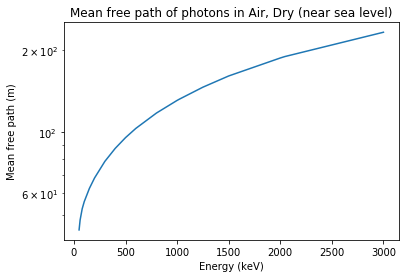

In [35]:
compound = 'Air, Dry (near sea level)'

# retrieve NIST compound data
comp_dat = bq.materials.fetch_compound_data()
display(comp_dat.head())
density = comp_dat.Density[comp_dat.Material == compound].values[0]
composition = comp_dat.Composition_symbol[comp_dat.Material == compound].values[0]
print('density (g/cm^3):', density)
print('composition:', composition)

# retrieve NIST XCOM cross sections
xd = bq.xcom.fetch_xcom_data(composition, e_range_kev=[50., 3000.])

# calculate mean free path
mfp_cm = 1 / (density * xd.total_wo_coh.values)
mfp_m = mfp_cm / 100.

plt.figure()
plt.title('Mean free path of photons in ' + compound)
plt.semilogy(xd.energy, mfp_m)
plt.xlabel('Energy (keV)')
plt.ylabel('Mean free path (m)')
plt.show()

# 5. Example 1: Identifying unknown spectral lines
From the previous spectrum, we see a line around 1408 keV that is not in the background.

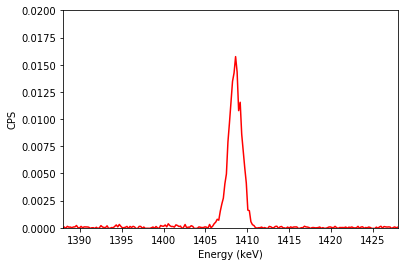

In [36]:
plt.figure()
plt.plot(bkgsub.energies_kev, bkgsub.cps_vals, 'r-')
plt.xlim(1388, 1428)
plt.ylim(0, 0.02)
plt.xlabel('Energy (keV)')
plt.ylabel('CPS')
plt.show()

Which isotope in the sample could be producing this line?

In [37]:
rad = bq.nndc.fetch_decay_radiation(
    type='Gamma',
    e_range=[1405, 1410],
    i_range=[5, None],  # at least 5% branching
    t_range=[3600, None],  # half-life >= 1 hour
)
display(rad[cols])

,Z,Element,A,Decay Mode,Radiation,Radiation Energy (keV),Radiation Intensity (%),Parent Energy Level (MeV)
0,27,CO,55,EC,G,1408.50+/-0.30,16.9+/-0.8,0.0
1,63,EU,152,EC,G,1408.0130+/-0.0030,20.87+/-0.09,0.0


Let's first consider Co-55. Are there other lines from that isotope present in the spectrum?

In [38]:
rad = bq.nndc.fetch_decay_radiation(
    nuc='Co-55',
    type='Gamma',
    i_range=(1, None),  # at least 1% branching
    e_range=(100, None),  # energy >= 100 keV
)
display(rad[cols])

,Z,Element,A,Decay Mode,Radiation,Radiation Energy (keV),Radiation Intensity (%),Parent Energy Level (MeV)
0,27,CO,55,EC,G,411.50+/-0.30,1.07+/-0.08,0.0
1,27,CO,55,EC,G,477.20+/-0.20,20.2+/-1.7,0.0
2,27,CO,55,EC,G,511,152+/-7,0.0
3,27,CO,55,EC,G,803.70+/-0.20,1.87+/-0.15,0.0
4,27,CO,55,EC,G,931.10+/-0.30,75,0.0
5,27,CO,55,EC,G,1316.60+/-0.30,7.10+/-0.30,0.0
6,27,CO,55,EC,G,1370.00+/-0.30,2.90+/-0.30,0.0
7,27,CO,55,EC,G,1408.50+/-0.30,16.9+/-0.8,0.0


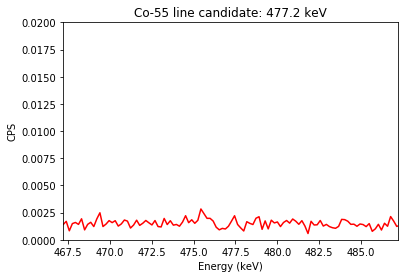

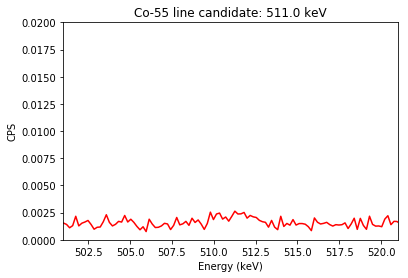

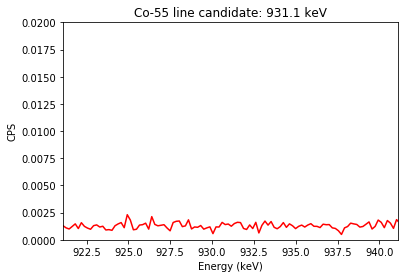

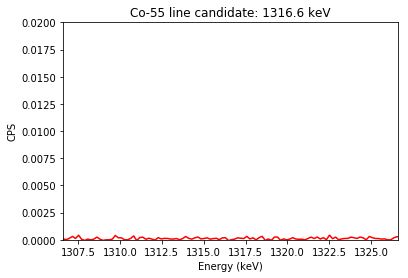

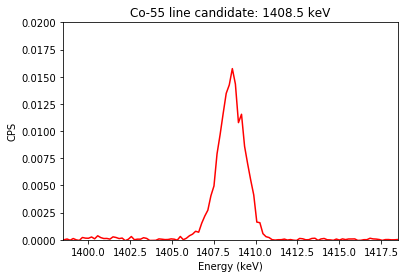

In [39]:
energies = rad['Radiation Energy (keV)'][rad['Radiation Intensity (%)'] > 5]
for en in energies:
    try:
        en = en.nominal_value
    except:
        pass
    plt.figure()
    plt.title('Co-55 line candidate: {:.1f} keV'.format(en))
    plt.plot(bkgsub.energies_kev, bkgsub.cps_vals, 'r-')
    plt.xlim(en - 10, en + 10)
    plt.ylim(0, 0.02)
    plt.xlabel('Energy (keV)')
    plt.ylabel('CPS')

Those lines are not present. Let's examine Eu-152:

In [40]:
rad = bq.nndc.fetch_decay_radiation(
    nuc='Eu-152',
    type='Gamma',
    i_range=(1, None),
    e_range=(100, None),
)
rad = rad[rad['Parent Energy Level (MeV)'] == 0]
display(rad[cols])

,Z,Element,A,Decay Mode,Radiation,Radiation Energy (keV),Radiation Intensity (%),Parent Energy Level (MeV)
4,63,EU,152,EC,G,121.78170+/-0.00030,28.53+/-0.16,0.0
5,63,EU,152,EC,G,244.6974+/-0.0008,7.55+/-0.04,0.0
6,63,EU,152,B-,G,344.2785+/-0.0012,26.59+/-0.20,0.0
7,63,EU,152,B-,G,411.1165+/-0.0012,2.237+/-0.013,0.0
8,63,EU,152,EC,G,443.9606+/-0.0016,2.827+/-0.014,0.0
9,63,EU,152,B-,G,778.9045+/-0.0024,12.93+/-0.08,0.0
10,63,EU,152,EC,G,867.3800+/-0.0030,4.230+/-0.030,0.0
11,63,EU,152,EC,G,964.057+/-0.005,14.51+/-0.07,0.0
12,63,EU,152,EC,G,1085.837+/-0.010,10.11+/-0.05,0.0
13,63,EU,152,B-,G,1089.737+/-0.005,1.734+/-0.011,0.0


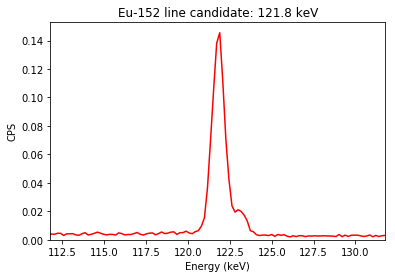

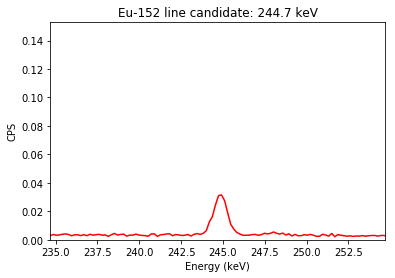

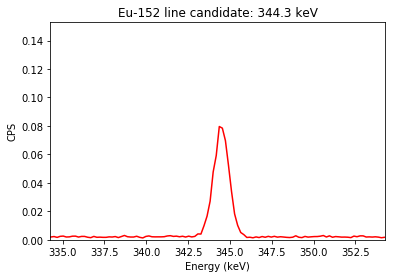

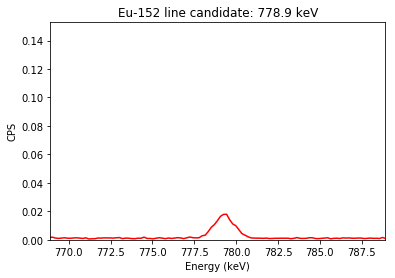

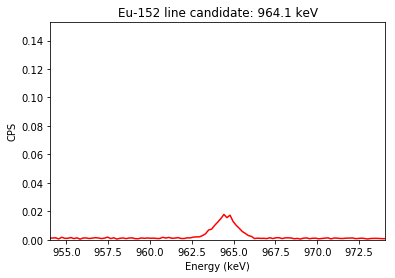

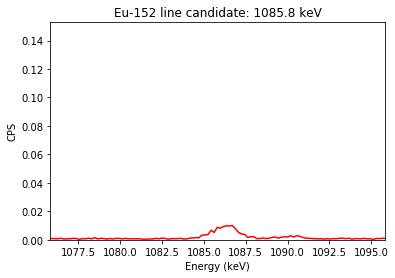

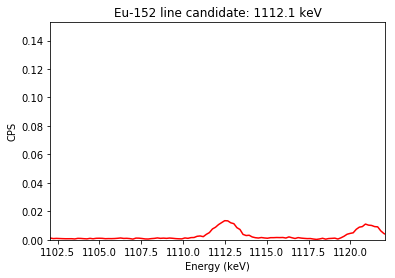

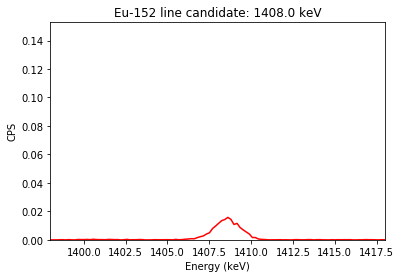

In [41]:
energies = rad['Radiation Energy (keV)'][rad['Radiation Intensity (%)'] > 5]
for en in energies:
    try:
        en = en.nominal_value
    except:
        pass
    plt.figure()
    plt.title('Eu-152 line candidate: {:.1f} keV'.format(en))
    plt.plot(bkgsub.energies_kev, bkgsub.cps_vals, 'r-')
    plt.xlim(en - 10, en + 10)
    plt.ylim(0)
    plt.xlabel('Energy (keV)')
    plt.ylabel('CPS')

Eu-152 looks like a good match.

In [42]:
# an equivalent way to do access these isotope data by using `fetch_wallet_card`
data = bq.nndc.fetch_wallet_card(
    z_range=(19, 19),
    a_range=(37, 44),
    elevel_range=(0, 0),  # ground states only
)
display(data)

,Z,Element,A,m,M,N,JPi,Energy Level (MeV),Decay Mode,Branching (%),Abundance (%),Mass Excess (MeV),T1/2 (s),T1/2 (txt)
0,19,K,37,,0,18,3/2+,0.0,EC,100.00,None,-24.80020+/-0.00009,1.226000e+00,1.226 S 0.007
1,19,K,38,,0,19,3+,0.0,EC,100.00,None,-28.80075+/-0.00020,4.581600e+02,7.636 M 0.018
2,19,K,39,,0,20,3/2+,0.0,,NaN,93.258+/-0.004,-33.807190+/-0.000005,inf,STABLE
3,19,K,40,,0,21,4-,0.0,B-,89.28,0.01170+/-0.00010,-33.53549+/-0.00006,3.938000e+16,1.248E+9 Y 0.003E+9
4,19,K,40,,0,21,4-,0.0,EC,10.72,0.01170+/-0.00010,-33.53549+/-0.00006,3.938000e+16,1.248E+9 Y 0.003E+9
5,19,K,41,,0,22,3/2+,0.0,,NaN,6.730+/-0.004,-35.559543+/-0.000004,inf,STABLE
6,19,K,42,,0,23,2-,0.0,B-,100.00,None,-35.02203+/-0.00011,4.447800e+04,12.355 H 0.007
7,19,K,43,,0,24,3/2+,0.0,B-,100.00,None,-36.5754+/-0.0004,8.028000e+04,22.3 H 0.1
8,19,K,44,,0,25,2-,0.0,B-,100.00,None,-35.7815+/-0.0004,1.327800e+03,22.13 M 0.19


# 6. Example 2: Activity of a 40 lb bag of KCl salt

In [43]:
# calculate number of K atoms in the sample
from scipy.constants import physical_constants
AMU = physical_constants['unified atomic mass unit'][0]

K = bq.Element('Potassium')
Cl = bq.Element('Cl')

mass = 18.1  # kg
mass_K = mass * K.atomic_mass / (K.atomic_mass + Cl.atomic_mass)
n_K = mass_K / AMU / K.atomic_mass
print('total mass: {:.2f} kg'.format(mass))
print('mass of K:  {:.2f} kg'.format(mass_K))
print('number of K nuclei: {:.2e}'.format(n_K))

total mass: 18.10 kg
mass of K:  9.49 kg
number of K nuclei: 1.46e+26


In [44]:
# calculate number of K-40 nuclei
K40 = bq.Isotope('K-40')
print('K-40 abundance: {:.4f}%'.format(K40.abundance))
n_K40 = n_K * K40.abundance.nominal_value / 100
print('number of K-40 nuclei: {:.2e}'.format(n_K40))

K-40 abundance: 0.0117+/-0.0001%
number of K-40 nuclei: 1.71e+22


In [45]:
# determine activity of K-40
# n(t) = n0 2^(-t / hl) = n0 exp(-t ln(2) / hl)
# dn/dt = -n0 ln(2) / hl exp(-t ln(2) / hl)
print('half-life: {:.3e} s'.format(K40.half_life))
print('half-life: {:.3e} y'.format(K40.half_life / (3600 * 24 * 365)))

activity_Bq = n_K40 * np.log(2) / K40.half_life  # could also use n_K40 * K40.decay_constant
print('activity: {:.2e} Bq'.format(activity_Bq))
activity_uCi = activity_Bq / 3.7e4
print('activity: {:.2e} uCi'.format(activity_uCi))

half-life: 3.938e+16 s
half-life: 1.249e+09 y
activity: 3.01e+05 Bq
activity: 8.14e+00 uCi


# 7. Features in development (contributions welcome!)

* `Spectrum.plot` method
* rebinning a `Spectrum`
* reading additional `Spectrum` file types (N42, CHN, CSV)
* writing `Spectrum` objects to various standard formats
* automatic peak finding and calibration
* fitting spectral features (e.g., gaussian lines with different background models)
* pypi.python.org registration ...

We meet biweekly during lunch on Tuesdays with our next meeting tomorrow: 4/10.